## Import Packages and Load Data

In [1]:
# Load prerequisite commands
%run "P:\Experiments\006 RPE Image Analysis (Christin)\RPE Morphology\2019-06-25 CLC2 RPE Morphology\Functions.py" 

In [2]:
# Define Mouse ID's, Mutations, and Tissue Types

mouse_num = ['1256', '1257', '1258', '1259', '1260', '1494', '1498', '1499', 
             '1500', '1501', '1502']
mut_types = ['WT', 'Het', 'KO']
age_type = ['P14', 'P30']
steps = 1

In [3]:
# Set working directory for loading images
%cd "P:\Experiments\006 RPE Image Analysis (Christin)\RPE Morphology\2019-06-25 CLC2 RPE Morphology\Images"

# Read in data from .tif
AF_647 = skimage.io.ImageCollection('*647.tif', load_func=imread_rgb)

# convert from image collection to list
ZO1 = [image for image in AF_647]

filenames = glob.glob('*647.tif')
filenames.sort(key=natural_keys) # Note the natural sorting definition so that 
                                 # filenames are in line with ImageCollection images

P:\Experiments\006 RPE Image Analysis (Christin)\RPE Morphology\2019-06-25 CLC2 RPE Morphology\Images


In [4]:
# Create factor lists to be used in dataframes later
mut = factor_maker(mut_types, filenames, steps)
mice = factor_maker(mouse_num, filenames, steps)

In [5]:
# load previosuly calculated numpy arrays of segemnted flatmounts
%cd "P:\Experiments\006 RPE Image Analysis (Christin)\RPE Morphology\2019-06-25 CLC2 RPE Morphology\Results\Flat Mount Area"

area_filenames = glob.glob('*.npy')
area_filenames.sort(key=natural_keys)

fm_area_image = [np.load(image) for image in area_filenames]

P:\Experiments\006 RPE Image Analysis (Christin)\RPE Morphology\2019-06-25 CLC2 RPE Morphology\Results\Flat Mount Area


In [6]:
# load previosuly calculated numpy arrays of segemnted RPE cells
%cd "P:\Experiments\006 RPE Image Analysis (Christin)\RPE Morphology\2019-06-25 CLC2 RPE Morphology\Results\Cell Seg"

cell_filenames = glob.glob('*.npy')
cell_filenames.sort(key=natural_keys)

cells = [np.load(image) for image in cell_filenames]

P:\Experiments\006 RPE Image Analysis (Christin)\RPE Morphology\2019-06-25 CLC2 RPE Morphology\Results\Cell Seg


## Calculate Cell Morphology Parameters

In [7]:
import joblib
from joblib import Parallel, delayed

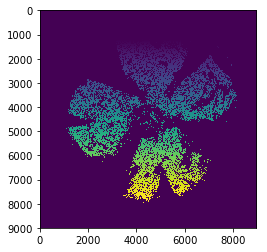

In [8]:
test_initial = cells[7]
test, n_left = mh.labeled.relabel(test_initial)
plt.imshow(test)

In [9]:
image_props_test = skimage.measure.regionprops(test)

In [10]:
Cells_to_remove = []
Cells_to_fix = []
Cells_not_to_fix = []

for j in tqdm(range(0, len(np.unique(test))-1)):
    solid = image_props_test[j].solidity
    if solid < .8:
        Cells_to_remove.append(j)
    if .8 < solid < .9:
        Cells_to_fix.append(j)
    if solid > .9:
        Cells_not_to_fix.append(j)

100%|███████████████████████████████████████████████████████████████████████████| 22444/22444 [00:25<00:00, 877.46it/s]


In [11]:
def hull(index, image):
    cv_image = convex_hull_image(image == index + 1)
    return(cv_image)

In [19]:
temper = "P:\Experiments\006 RPE Image Analysis (Christin)\RPE Morphology\2019-06-25 CLC2 RPE Morphology\Temp"

cool = (Parallel(n_jobs=8, backend='loky', prefer="threads", temp_folder = "temper", max_nbytes=1e3)\
        (delayed(hull)(j, test) for j in tqdm(Cells_to_fix)))

 35%|███████████████████████████▉                                                   | 815/2301 [07:06<10:55,  2.27it/s]exception calling callback for <Future at 0x25b097c4198 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
'''
Traceback (most recent call last):
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\site-packages\joblib\externals\loky\process_executor.py", line 624, in _queue_management_worker
    result_item = result_reader.recv()
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\multiprocessing\connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\multiprocessing\connection.py", line 318, in _recv_bytes
    return self._get_more_data(ov, maxsize)
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\multiprocessing\connection.py", line 340, in _get_more_data
    ov, err = _winapi.ReadFile(self._handle, left, overlapped=True)
MemoryError
'''

The above exception was the direct caus

joblib.externals.loky.process_executor._RemoteTraceback: 
'''
Traceback (most recent call last):
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\site-packages\joblib\externals\loky\process_executor.py", line 624, in _queue_management_worker
    result_item = result_reader.recv()
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\multiprocessing\connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\multiprocessing\connection.py", line 318, in _recv_bytes
    return self._get_more_data(ov, maxsize)
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\multiprocessing\connection.py", line 340, in _get_more_data
    ov, err = _winapi.ReadFile(self._handle, left, overlapped=True)
MemoryError
'''

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\paz2009\Anaconda3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_gl

TypeError: can only concatenate str (not "list") to str

In [ ]:
remove = np.zeros(test.shape)

for j in tqdm(Cells_to_remove):
    remove += test == j+1

In [ ]:
for j in tqdm(Cells_to_fix):
    if solid < .8:
        remove += n == j+1
    if .8 < solid < .9:
        fixed += convex_hull_image(n == j+1)
    if solid > .9:
        other += n == j+1

In [ ]:
fixed2 = np.array(fixed, dtype=bool)
remove2 = np.array(remove, dtype=bool)
other2 = np.array(other, dtype=bool)

overlap = fixed2 * other2
fixed3 = fixed2 * ~overlap
other3 = other2 * ~overlap

final_1 = other3 + skimage.morphology.binary_erosion(fixed3, disk(1))
final_2 = final_1 * ~remove2

yep, no = mh.label(final_2)

plt.figure(figsize = (10,10))
plt.imshow(yep, cmap=rmap)

In [ ]:
# Calculate number of sides per cell

num_of_sides = []
side_images = []
sides_per_image = []

for i in range(0, len(cells)):
    side_image = np.zeros(cells[i].shape)
    for j in range(1, np.max(cells[i])):
        m = cells[i] == j
        coords = corner_peaks(corner_harris(m), min_distance=5)
        coords_subpix = corner_subpix(m, coords, window_size=13)
        num_of_sides.append(len(coords_subpix))
        side_image += m*len(coords_subpix)
    side_images.append(side_image)  
    
    mouse_series = pd.Series([mice[i]] * np.max(cells[i]))
    mut_series = pd.Series([mut[i]] * np.max(cells[i]))
    cell_num_series = pd.Series(np.linspace(1, np.max(cells[i]), np.max(cells[i]), dtype=int))
    side_series = pd.Series(num_of_sides[:])
    total = pd.concat([mouse_series, mut_series, cell_num_series, side_series], axis=1)
    
    total.columns = ['Mouse', 'Mut', 'Cell Number', 'Number of Sides']
    sides_per_image.append(total[0:-1])
    num_of_sides.clear()
    
    plt.figure(figsize = (12,12))
    plt.imshow(side_image, cmap='Greys')
    plt.axis('off')

    plt.savefig("Side Number %s %s" % (mice[i], mut[i]), dpi=300)
    plt.close()

sides = pd.concat(sides_per_image, axis=0)
sides.columns = ['Mouse', 'Mut', 'Cell Number', 'Number of Sides']

In [ ]:
# Calculate Cell Morphology Parameters

cell_area = []
cell_ecc = []
props_per_image = []

for i in range(0, len(cells)):
    image_props = skimage.measure.regionprops(cells[i])
    for j in range(1, np.max(cells[i])):
        cell_area.append(image_props[j].area)
        cell_ecc.append(image_props[j].eccentricity)
    
    mouse_series = pd.Series([mice[i]] * np.max(cells[i]))
    mut_series = pd.Series([mut[i]] * np.max(cells[i]))
    cell_num_series = pd.Series(np.linspace(1, np.max(cells[i]), np.max(cells[i]), dtype=int))
    area_series = pd.Series(cell_area[:])
    ecc_series = pd.Series(cell_ecc[:])
    total = pd.concat([mouse_series, mut_series, cell_num_series, area_series, ecc_series], axis=1)
    
    total.columns = ['Mouse', 'Mut', 'Cell Number', 'Area', 'Ecc']
    props_per_image.append(total[0:-1])
    
    cell_area.clear()
    cell_ecc.clear()
    
props = pd.concat(props_per_image, axis=0)
props.columns = ['Mouse', 'Mut', 'Cell Number', 'Area', 'Ecc']

## Plot Results

In [ ]:
for index, image in enumerate(ZO1):
    overlay = np.array(cells[index], dtype=bool)
    overlay_label = skimage.color.label2rgb(overlay, image, ['black', 'green' ])
    
    plt.figure(figsize = (15,15))
    plt.imshow(overlay_label)
    plt.axis('off')
    
    plt.savefig("Overlay %s %s" % (mice[index], mut[index]), dpi=300)
    plt.close()

In [ ]:
plt.figure(figsize = (8,6))
plt.hist(props.loc[props['Mut'] == 'WT']['Area'], bins=list(np.arange(0,2750,250)))
plt.savefig("WT Area Hist", dpi=150)

In [ ]:
plt.figure(figsize = (8,6))
plt.hist(props.loc[props['Mut'] == 'IHH']['Area'], bins=list(np.arange(0,2750,250)), color='red')
plt.savefig("IHH Area Hist", dpi=150)

In [ ]:
plt.figure(figsize = (8,6))
sns.kdeplot(props.loc[props['Mut'] == 'WT']['Area'], shade=True, bw=.1, label='WT')
sns.kdeplot(props.loc[props['Mut'] == 'IHH']['Area'], shade=True, bw=.1, color="red", label='IHH')
plt.xlim(0, 2000)
plt.savefig("WT-IHH Area Density Plot", dpi=150)

In [ ]:
plt.figure(figsize = (8,6))
plt.hist(props.loc[props['Mut'] == 'WT']['Ecc'], bins=list(np.arange(0,1.1,.1)))
plt.savefig("WT Eccentricity Hist", dpi=150)

In [ ]:
plt.figure(figsize = (8,6))
plt.hist(props.loc[props['Mut'] == 'IHH']['Ecc'], bins=list(np.arange(0,1.1,.1)), color="red")
plt.savefig("IHH Eccentricity Hist", dpi=150)

In [ ]:
plt.figure(figsize = (8,6))
sns.kdeplot(props.loc[props['Mut'] == 'WT']['Ecc'], shade=True, bw=.04, label='WT')
sns.kdeplot(props.loc[props['Mut'] == 'IHH']['Ecc'], shade=True, bw=.04, color="red", label='IHH')
plt.xlim(0, 1.2)
plt.savefig("WT-IHH Eccentricity Density Plot", dpi=150)

In [ ]:
plt.figure(figsize = (8,6))
plt.hist(sides.loc[sides['Mut'] == 'WT']['Number of Sides'], bins=list(np.arange(3,13,1)))
plt.xlim(3, 15)
plt.savefig("WT Side Number Hist", dpi=150)

In [ ]:
plt.figure(figsize = (8,6))
plt.hist(sides.loc[sides['Mut'] == 'IHH']['Number of Sides'], bins=list(np.arange(3,13,1)), color='red')
plt.xlim(3, 15)
plt.savefig("IHH Side Number Hist", dpi=150)

In [ ]:
plt.figure(figsize = (8,6))
sns.kdeplot(sides.loc[sides['Mut'] == 'WT']['Number of Sides'], shade=True, bw=.5, label='WT');
sns.kdeplot(sides.loc[sides['Mut'] == 'IHH']['Number of Sides'], shade=True, bw=.5, color="red", label='IHH');
plt.xlim(3, 15)
plt.savefig("WT-IHH Side Number Density Plot", dpi=150)

In [ ]:
# Function to replot segmented cell images with random colors

for i in range(0, len(cells)):
    blank_image = np.zeros(cells[i].shape)
    for j in tqdm(range(1, np.max(cells[i]))):
        m = cells[i] == j
        blank_image += m*random.randint(1, 100000)
    
    test = skimage.img_as_float(blank_image)
    
    plt.figure(figsize = (30, 30))
    plt.imshow(test, cmap=rmap)
    plt.axis('off')

    plt.savefig("Cell Outline Random Colors %s %s" % (mice[i], mut[i]), dpi=300)
    plt.close()